# Cat-Dog predictor using PyTorch
In this project I made use of a convolutional neural network (CNN) to predict if the animal in a photo is a dog or a cat (binary selection). 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import os
import numpy as np
import matplotlib.pyplot as plt
import random

class CustomImageDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.transform = transform
        self.images = os.listdir(root)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root, self.images[idx])
        image = Image.open(img_name)
        if self.transform:
            image = self.transform(image)
        return image

In [18]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirecories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [4]:
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=validation_dir, transform=transform)
test_dataset = CustomImageDataset(root=test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128)
test_loader = DataLoader(test_dataset, batch_size=128)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


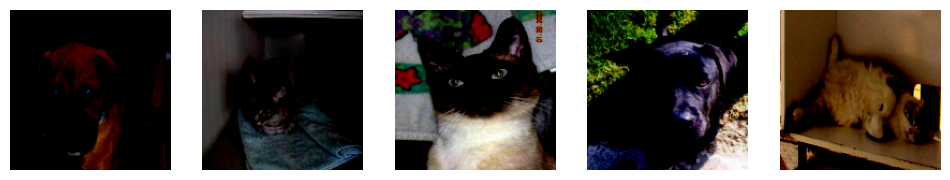

In [7]:
def show_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 4))
    for ax, img in zip(axes, images):
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax.axis('off')
    plt.show()

# Get a batch of training data
for images, labels in train_loader:
    # Show example images
    random_indices = random.sample(range(len(images)), 5)
    random_images = [images[i] for i in random_indices]
    show_images(random_images)

    break 

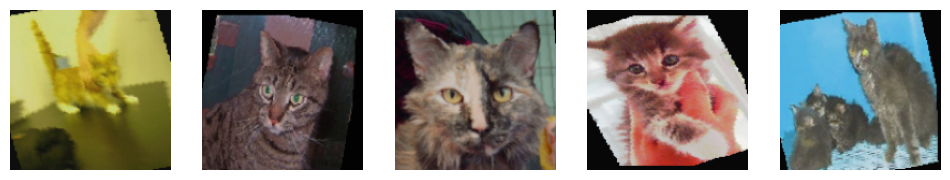

In [14]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),      
    transforms.RandomRotation(20),           
    transforms.RandomAffine(0, shear=15, scale=(0.85, 1.15)),  
    transforms.RandomPerspective(),          
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
    transforms.RandomResizedCrop((IMG_HEIGHT, IMG_WIDTH), scale=(0.8, 1.0), ratio=(0.75, 1.333)),  
    transforms.ToTensor(),                 
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)

batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

augmented_images = [train_dataset[i][0] for i in range(5)]

show_images(augmented_images)

In [21]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  
        self.pool = nn.MaxPool2d(2, 2)  
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  
        self.dropout = nn.Dropout2d(p=0.2)  
        self.fc1 = nn.Linear(64 * (IMG_HEIGHT//4) * (IMG_WIDTH//4), 128)  
        self.fc2 = nn.Linear(128, 2) 
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)  
        x = F.relu(self.conv2(x)) 
        x = self.pool(x)  
        x = F.relu(self.conv3(x))
        x = self.dropout(x)  
        x = x.view(-1, 64 * (IMG_HEIGHT//4) * (IMG_WIDTH//4))
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))  
        x = self.fc2(x)
        return x

model = CNN()
model = model.to(device)
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (dropout): Dropout2d(p=0.2, inplace=False)
  (fc1): Linear(in_features=87616, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0
    
    for (inputs, labels) in train_loader:
        # Move data to GPU if available
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Update running loss
        running_loss += loss.item()
        
        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Accuracy: {(correct/total)*100:.2f}%")

Epoch 1/15, Loss: 0.8268, Accuracy: 51.75%
Epoch 2/15, Loss: 0.6934, Accuracy: 50.00%
Epoch 3/15, Loss: 0.6923, Accuracy: 51.00%
Epoch 4/15, Loss: 0.6917, Accuracy: 52.50%
Epoch 5/15, Loss: 0.6893, Accuracy: 54.30%
Epoch 6/15, Loss: 0.6867, Accuracy: 54.15%
Epoch 7/15, Loss: 0.6830, Accuracy: 55.90%
Epoch 8/15, Loss: 0.6788, Accuracy: 55.70%
Epoch 9/15, Loss: 0.6729, Accuracy: 58.25%
Epoch 10/15, Loss: 0.6736, Accuracy: 58.85%
Epoch 11/15, Loss: 0.6697, Accuracy: 59.80%
Epoch 12/15, Loss: 0.6645, Accuracy: 60.10%
Epoch 13/15, Loss: 0.6552, Accuracy: 62.90%
Epoch 14/15, Loss: 0.6652, Accuracy: 59.40%
Epoch 15/15, Loss: 0.6516, Accuracy: 62.80%


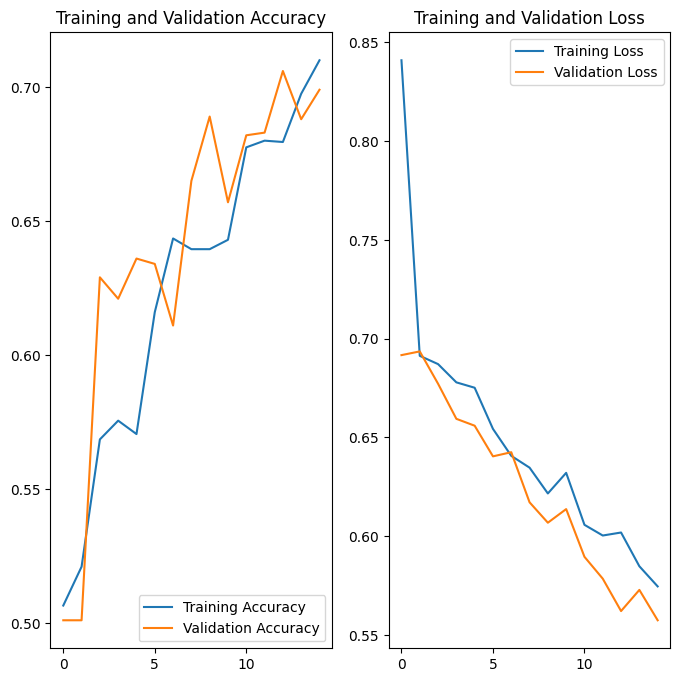

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [12]:
predictions = model.predict(test_data_gen)
probabilities = [1 if a[0]<a[1] else 0 for a in predictions]
# probabilities

1/1 [==============================] - 0s 178ms/step


In [13]:
print(len(probabilities))

50


In [39]:
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  if round(probability) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100
print('Final accuracy of: {}%'.format(percentage_identified))

dogs_or_cats_answers = ['Dog' if i==1 else 'Cat' for i in answers]
dogs_or_cats_predict = ['Dog' if i==1 else 'Cat' for i in probabilities]

Final accuracy of: 74.0%


In [40]:
def generate_random_numbers(n, i, j):
    return [random.randint(i, j) for _ in range(n)]

(50, 150, 150, 3)


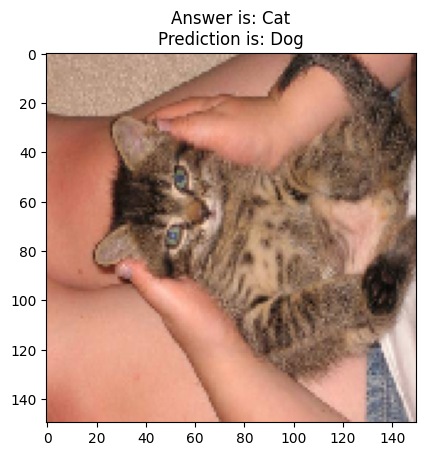

(50, 150, 150, 3)


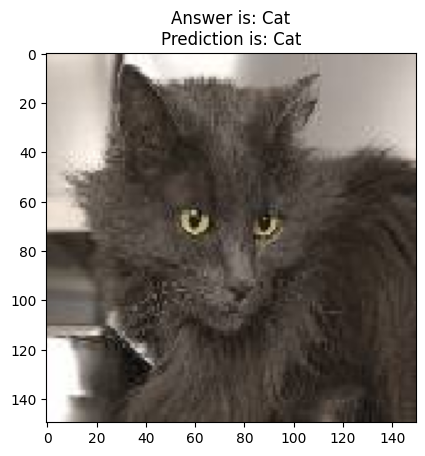

(50, 150, 150, 3)


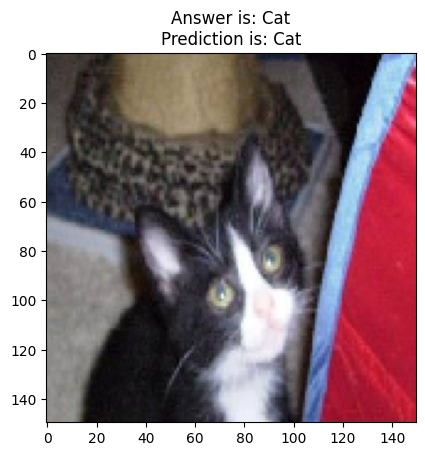

(50, 150, 150, 3)


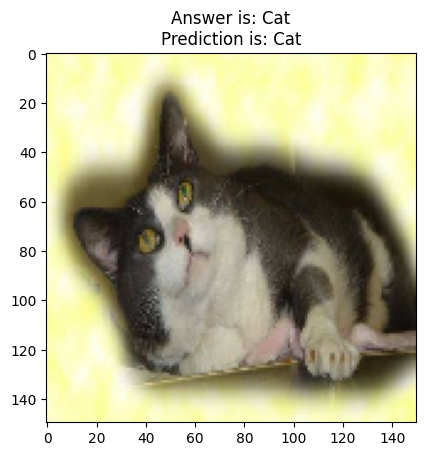

(50, 150, 150, 3)


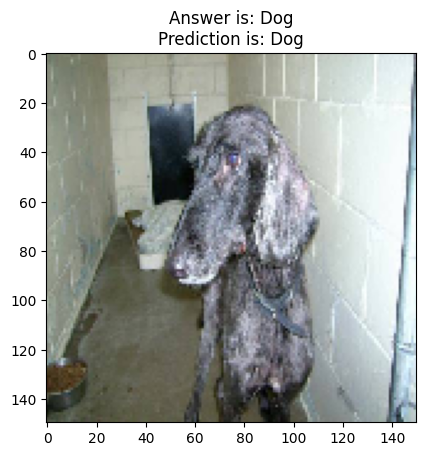

In [41]:
random_numbers = generate_random_numbers(5, 0, 49)
for i in random_numbers:
    img, label = test_data_gen.next()
    print(img.shape)   #  (1,256,256,3)
    plt.imshow(img[i])
    plt.title('Answer is: {}\nPrediction is: {}'.format(dogs_or_cats_answers[i], dogs_or_cats_predict[i]))
    plt.show()